In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import folium
from geopy.distance import geodesic
from pyproj import Geod
import numpy as np
from shapely.wkt import loads
from geopy.distance import geodesic
from shapely.geometry import Point, Polygon
from sqlalchemy import create_engine
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd
import importlib
from pyproj import CRS, Transformer
from scipy.integrate import quad
from scipy.integrate import cumtrapz


from pyproj import Geod
from sklearn.metrics import mean_squared_error
geod = Geod(ellps="WGS84")
from shapely.ops import nearest_points
from geopy.distance import geodesic
import mplleaflet
import seaborn as sns
from shapely.wkt import loads

# Evaluate model results in training

In [2]:

def get_predictions_datahora(conn):
    query = f'''
            select
            a.id,
            a.filename,
            a.datahora_epoch_pred,
            a.datahora_epoch_resposta,
            b.ordem,
            b.linha
            from public.vehicle_tracking_pred_datahora a
                left join vehicle_tracking_treino_latlong b
            on (a.filename = b.filename and a.id = b.id)
            '''
        
    # Carregar dados em um GeoDataFrame
    df = pd.read_sql(query, conn)

    return df



def get_predictions_latlong(conn):
    query = f'''
            select
            a.id,
            a.filename,
            a.latitude_resposta,
            a.longitude_resposta,
            a.latitude_pred,
            a.longitude_pred,
            b.ordem,
            b.linha
            from public.vehicle_tracking_pred_latlong a
                left join vehicle_tracking_treino_datahora b
            on (a.filename = b.filename and a.id = b.id)
            '''
        
    # Carregar dados em um GeoDataFrame
    df = pd.read_sql(query, conn)

    return df



In [3]:
conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)



df_pred_datahora = get_predictions_datahora(conn)
df_pred_latlong = get_predictions_latlong(conn)
conn.close()


C:\Users\lucas\AppData\Local\Temp\ipykernel_27088\365661714.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\lucas\AppData\Local\Temp\ipykernel_27088\365661714.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


### Model Metrics for predicting time

In [14]:
# Converter timestamps para datetime
from sklearn.metrics import mean_squared_error
df_pred_datahora['datahora_pred'] = pd.to_datetime(df_pred_datahora['datahora_epoch_pred'], unit='ms')
df_pred_datahora['datahora_resposta'] = pd.to_datetime(df_pred_datahora['datahora_epoch_resposta'], unit='ms')

# Calculate RMSE
rmse_geral = np.sqrt(mean_squared_error(df_pred_datahora['datahora_epoch_resposta'], df_pred_datahora['datahora_epoch_pred']))


print('RMSE (minutes) for predicting time', rmse_geral/1000/60)


RMSE (minutes) for predicting time 457.8198609724113


- RMSE is higher then expected

C:\Users\lucas\AppData\Local\Temp\ipykernel_27088\1406698375.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_por_dia_da_semana = df_pred_datahora.groupby('dia_da_semana').apply(lambda x: np.sqrt(mean_squared_error(x['datahora_epoch_resposta'], x['datahora_epoch_pred'])))


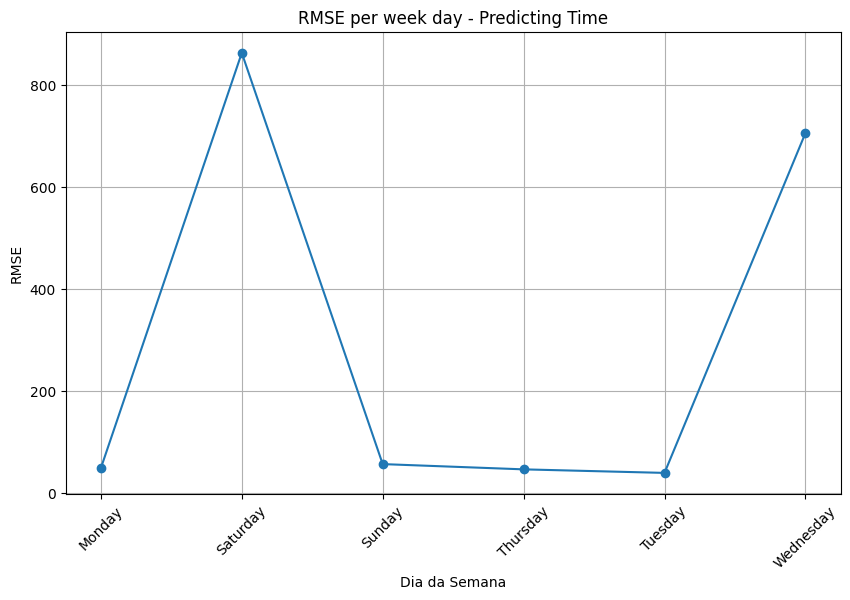

In [56]:
# Calculate RMSE for each day of the week
df_pred_datahora['dia_da_semana'] = df_pred_datahora['datahora_resposta'].dt.day_name()
rmse_por_dia_da_semana = df_pred_datahora.groupby('dia_da_semana').apply(lambda x: np.sqrt(mean_squared_error(x['datahora_epoch_resposta'], x['datahora_epoch_pred'])))
rmse_por_dia_da_semana = rmse_por_dia_da_semana/1000/60
# Plot RMSE for each day of the week
plt.figure(figsize=(10, 6))
plt.plot(rmse_por_dia_da_semana.index, rmse_por_dia_da_semana, marker='o')
plt.title('RMSE per week day - Predicting Time')
plt.xlabel('Dia da Semana')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


- Saturday and Wednesday showed very high results for what was expected

C:\Users\lucas\AppData\Local\Temp\ipykernel_27088\599959874.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_por_linha = df_pred_datahora.groupby('linha').apply(lambda x: np.sqrt(mean_squared_error(x['datahora_epoch_resposta'], x['datahora_epoch_pred'])))


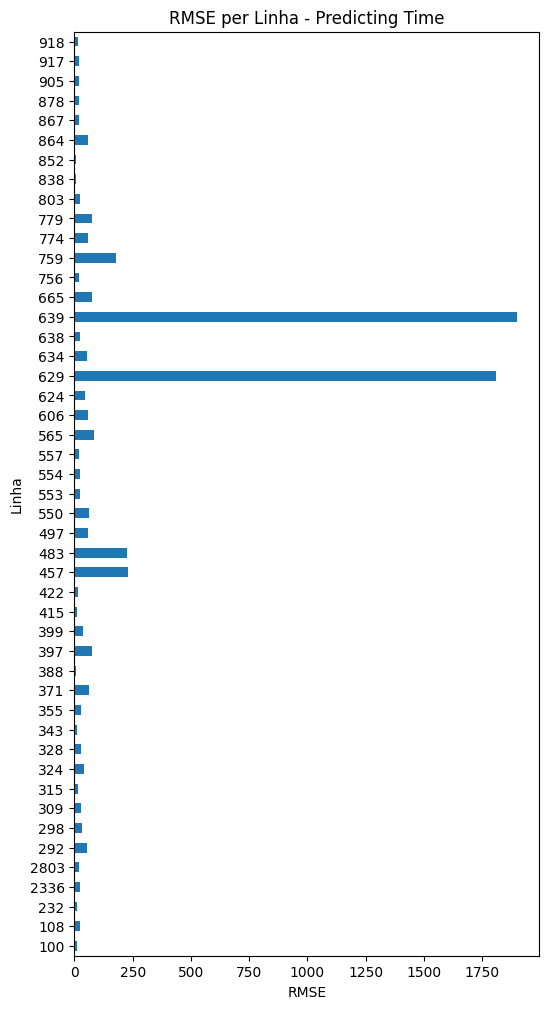

In [55]:

# Calculate RMSE for each line
rmse_por_linha = df_pred_datahora.groupby('linha').apply(lambda x: np.sqrt(mean_squared_error(x['datahora_epoch_resposta'], x['datahora_epoch_pred'])))
rmse_por_linha = rmse_por_linha/1000/60
# Plotar gráfico do RMSE por linha (invertido)
plt.figure(figsize=(6, 12))
rmse_por_linha.plot(kind='barh')  # Usar barh para gráfico horizontal
plt.title('RMSE per Linha - Predicting Time')
plt.xlabel('RMSE')
plt.ylabel('Linha')
plt.show()

- 639 and 629 showed very disparate results, let's evaluate the rmse without them

In [45]:
# Converter timestamps para datetime
from sklearn.metrics import mean_squared_error
df_pred_datahora['datahora_pred'] = pd.to_datetime(df_pred_datahora['datahora_epoch_pred'], unit='ms')
df_pred_datahora['datahora_resposta'] = pd.to_datetime(df_pred_datahora['datahora_epoch_resposta'], unit='ms')

df_pred_datahora_filtered = df_pred_datahora[~df_pred_datahora['linha'].isin(['639', '629'])]

# Calculate RMSE
rmse_geral = np.sqrt(mean_squared_error(df_pred_datahora_filtered['datahora_epoch_resposta'], df_pred_datahora_filtered['datahora_epoch_pred']))


print('RMSE (minutes) for predicting time without lines 629 and 639:', rmse_geral/1000/60)


RMSE (minutes) for predicting time without lines 629 and 639: 61.93228077435175


### Model metrics for predicting lat long

In [49]:

# Combinação de latitude e longitude em vetores
real_coords = np.vstack((df_pred_latlong['latitude_resposta'], df_pred_latlong['longitude_resposta'])).T
pred_coords = np.vstack((df_pred_latlong['latitude_pred'], df_pred_latlong['longitude_pred'])).T

# Calcular RMSE combinado para latitude e longitude
mse_combined = mean_squared_error(real_coords, pred_coords)
rmse_combined = np.sqrt(mse_combined)
rmse_combined

print('RMSE for lat long prediction:', rmse_combined)


RMSE for lat long prediction: 0.06466036716437804


C:\Users\lucas\AppData\Local\Temp\ipykernel_27088\3221505329.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_por_linha = df_pred_latlong.groupby('linha').apply(lambda x: np.sqrt(mean_squared_error(


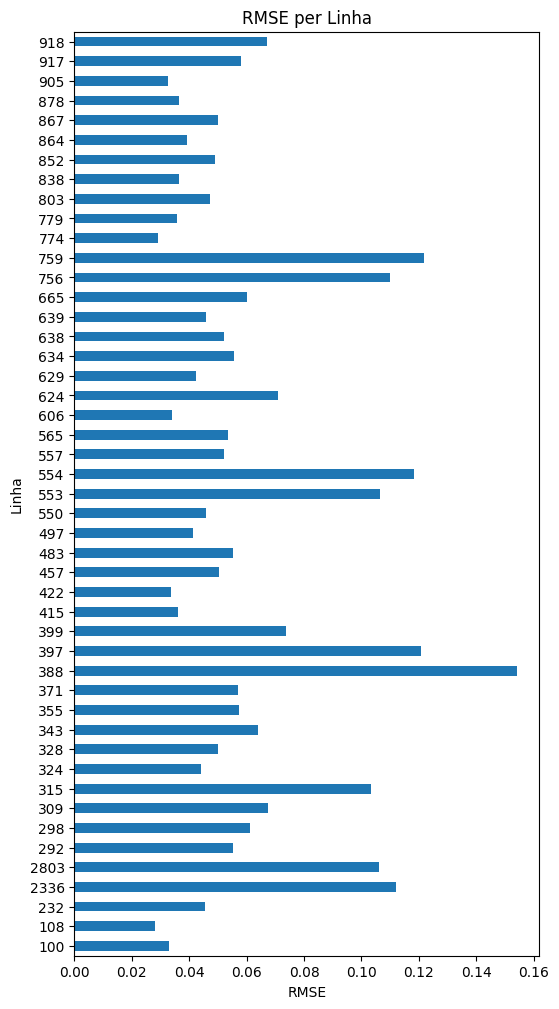

In [54]:

# Calculate RMSE for each line
rmse_por_linha = df_pred_latlong.groupby('linha').apply(lambda x: np.sqrt(mean_squared_error(
    [x['longitude_resposta'], x['latitude_resposta']], 
    [x['longitude_pred'], x['latitude_pred']]
    ))
)
# Plotar gráfico do RMSE por linha (invertido)
plt.figure(figsize=(6, 12))
rmse_por_linha.plot(kind='barh')  # Usar barh para gráfico horizontal
plt.title('RMSE per Linha')
plt.xlabel('RMSE')
plt.ylabel('Linha')
plt.show()

- In this case, it wasn't just two lines that stood out with higher results than normal

In [57]:
data = df_pred_latlong['filename'].str.split('-', expand=True)

data = data[1] + data[2] + data[3].str[:-5] + '00'

df_pred_latlong['filename_data'] = pd.to_datetime(data, format='%Y%m%d_%H%M')

In [ ]:
# Calculate RMSE for each day of the week
df_pred_datahora['dia_da_semana'] = df_pred_latlong['filename_data'].dt.day_name()
rmse_por_dia_da_semana = df_pred_datahora.groupby('dia_da_semana').apply(lambda x: np.sqrt(mean_squared_error(
    [x['longitude_resposta'], x['latitude_resposta']], 
    [x['longitude_pred'], x['latitude_pred']]
    ))
)
# Plot RMSE for each day of the week
plt.figure(figsize=(10, 6))
plt.plot(rmse_por_dia_da_semana.index, rmse_por_dia_da_semana, marker='o')
plt.title('RMSE per week day - Predicting Time')
plt.xlabel('Dia da Semana')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
